# RestNet Implementation

This example implements a ResNet network by implementing both ResNet identity- and convolution blocks. The network is then used for classifying blood cell types. Original images are from https://www.kaggle.com/paultimothymooney/blood-cells. Training uses two callbacks, which are:

* **EarlyStopping**. This callback stops training when a monitored metric has stopped improving.
* **ModelCheckpoint**. This callback saves the weights based on some criteria, like best model based on validation loss.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, \
  BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.optimizers import Adam

from glob import glob
import gdown
import zipfile
import utils

tensorflow version: 2.10.0


In [2]:
def download_blood_cells_data():
    url = 'https://drive.google.com/file/d/15_VKmPuwkHye_8z8MdBx7EbwrS_Wdhog/view?usp=sharing'
    output = './large_files/blood_cells.zip'
    if not os.path.exists('./large_files/blood_cells'):
        gdown.download(url, output, quiet=False, fuzzy=True)
        with zipfile.ZipFile('./large_files/blood_cells.zip', 'r') as zip_ref:
            zip_ref.extractall('./large_files')

In [3]:
# Download blood cells data
download_blood_cells_data()

Downloading...
From: https://drive.google.com/uc?id=15_VKmPuwkHye_8z8MdBx7EbwrS_Wdhog
To: /home/jarno/projects/deep-learning-examples/TensorFlow/large_files/blood_cells.zip
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105M/105M [00:26<00:00, 4.05MB/s]


In [4]:
src_path_training = os.path.join(os.path.realpath('.'), 'large_files', 'blood_cells', 'TRAIN')
src_path_test = os.path.join(os.path.realpath('.'), 'large_files', 'blood_cells', 'TEST')

image_size = [100, 100]

training_images = glob(src_path_training + '/*/*.jp*g')
test_images = glob(src_path_test + '/*/*.jp*g')
folders = glob(src_path_training + '/*')

print(f'Number of training images: {len(training_images)}')
print(f'Number of testing images: {len(test_images)}')
print(f'Number of classes: {len(folders)}')

Number of training images: 9957
Number of testing images: 2487
Number of classes: 4


In [5]:
def resnet_identity_block(input_, kernel_size, filters):
    '''
    ResNet identity block. Skip connection can be thought of being
    an identity function meaning that the signal stays the same, i.e. f(x) = x
    '''
    
    f1, f2, f3 = filters
    
    # 1x1 convolution with f1 number of filters
    # We end up with m*n*f1 feature map/image
    x = Conv2D(f1, (1, 1), kernel_initializer='he_normal')(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3, (1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = add([x, input_])
    x = Activation('relu')(x)
    
    return x

In [6]:
def resnet_conv_block(input_, kernel_size, filters, strides=(2, 2)):
    '''
    Resnet convolution block. Convolution is applied to the skip connection branch,
    before adding it to the normal branch.
    '''
    f1, f2, f3 = filters
    
    # 1x1 convolution with f1 number of filters
    # We end up with m*n*f1 feature map/image
    x = Conv2D(f1, (1, 1), kernel_initializer='he_normal')(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3, (1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    # Skip connection with convolution
    x_ = Conv2D(f3, (1, 1), strides=strides, kernel_initializer='he_normal')(x)
    x_ = BatchNormalization()(x_)
    
    x = add([x, x_])
    x = Activation('relu')(x)
    
    return x

In [7]:
# Create a ResNet model
i = Input(shape=image_size + [3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid',
          kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = resnet_conv_block(x, 3, [64, 64, 256], strides=(1, 1))
x = resnet_identity_block(x, 3, [64, 64, 256])
x = resnet_identity_block(x, 3, [64, 64, 256])

x = resnet_conv_block(x, 3, [128, 128, 512], strides=(1, 1))
x = resnet_identity_block(x, 3, [128, 128, 512])
x = resnet_identity_block(x, 3, [128, 128, 512])
x = resnet_identity_block(x, 3, [128, 128, 512])

x = Flatten()(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(i, prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 64)  256         ['conv2d[0][0]']             

 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 25, 25, 64)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 25, 25, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 25, 25, 256)  0           ['batch_normalization_10[0][0]', 
          

 batch_normalization_20 (BatchN  (None, 25, 25, 512)  2048       ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_5 (Add)                    (None, 25, 25, 512)  0           ['batch_normalization_20[0][0]', 
                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 25, 25, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 25, 25, 128)  65664       ['activation_18[0][0]']          
                                                                                                  
 batch_nor

Found 9957 images belonging to 4 classes.
Normalization, mean: [[[172.72804 163.35103 168.51076]]]
Normalization, standard deviation: [[[68.536606 68.20741  67.757805]]]
Found 9957 images belonging to 4 classes.
Image classes
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
Displaing an image from the generator


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image type: <class 'numpy.ndarray'>
Image max value: 1.1777139902114868
Image min value: -2.520230531692505


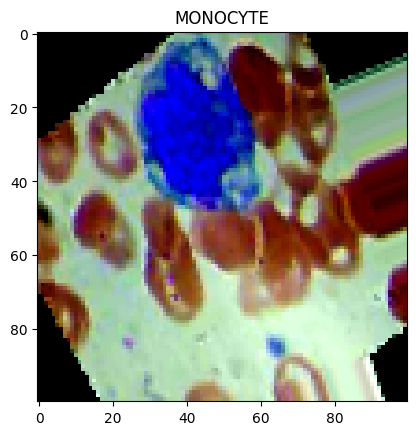

In [8]:
dir_iter = DirectoryIterator(src_path_training, None, target_size=image_size, batch_size=128)
img_batch, class_batch = dir_iter.next()

# Create an image data generator in order to augment the input data
gen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    #shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True)

# Calculate the statistics
gen.fit(img_batch)
print(f'Normalization, mean: {gen.mean}')
print(f'Normalization, standard deviation: {gen.std}')

test_gen = gen.flow_from_directory(src_path_training, target_size=image_size)

print('Image classes')
print(test_gen.class_indices)

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# We expect the image to look 'strange' to the using the preprocessor
print('Displaing an image from the generator')
for x, y in test_gen:
    plt.title(labels[np.argmax(y[0])])
    print(f'Image type: {type(x[0])}')
    print(f'Image max value: {np.max(x[0])}')
    print(f'Image min value: {np.min(x[0])}')
    plt.imshow(x[0])
    plt.show()
    break

In [9]:
epochs = 20
batch_size = 64

print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

# Training data generator
training_generator = gen.flow_from_directory(
    src_path_training,
    target_size = image_size,
    shuffle = True,
    batch_size = batch_size)

# Validation data generator
validation_generator = gen.flow_from_directory(
    src_path_test,
    target_size = image_size,
    shuffle = True,
    batch_size = batch_size)

# Train the model with callbacks
# - first callback is for early stopping
# - second callback is for storing the best model
checkpoint_filepath = './large_files/checkpoint'
r = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs = epochs,
    steps_per_epoch = len(training_images) // batch_size,
    validation_steps = len(test_images) // batch_size,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'loss',
            patience = 3,
            restore_best_weights = True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only = True,
            monitor = 'val_accuracy',
            mode = 'max',
            save_best_only = True)
    ]
)

Epochs: 20
Batch size: 64
Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Epoch 1/20
155/155 [==============================] - 41s 240ms/step - loss: 15.0799 - accuracy: 0.3514 - val_loss: 101.8893 - val_accuracy: 0.3059
Epoch 2/20
155/155 [==============================] - 37s 240ms/step - loss: 0.9529 - accuracy: 0.6431 - val_loss: 0.9943 - val_accuracy: 0.6410
Epoch 3/20
155/155 [==============================] - 37s 235ms/step - loss: 0.5431 - accuracy: 0.7865 - val_loss: 0.7997 - val_accuracy: 0.6900
Epoch 4/20
155/155 [==============================] - 37s 238ms/step - loss: 0.3445 - accuracy: 0.8637 - val_loss: 0.5993 - val_accuracy: 0.7701
Epoch 5/20
155/155 [==============================] - 37s 239ms/step - loss: 0.2599 - accuracy: 0.8982 - val_loss: 0.3609 - val_accuracy: 0.8343
Epoch 6/20
155/155 [==============================] - 37s 237ms/step - loss: 0.2101 - accuracy: 0.9195 - val_loss: 0.5137 - val_accuracy: 0.8002
Epoch 7/20
155/15

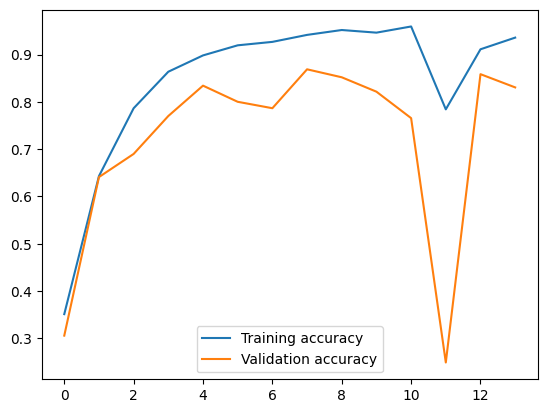

In [10]:
# Plot accuracy
plt.plot(r.history['accuracy'], label='Training accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()

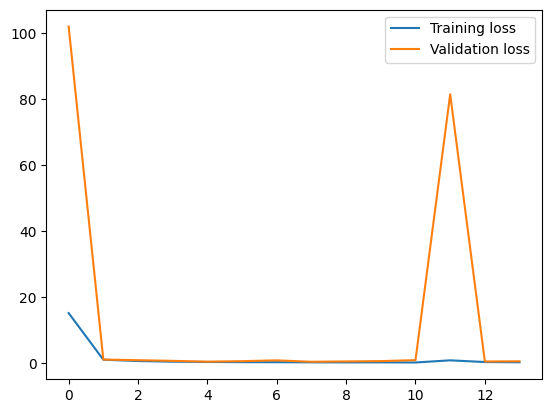

In [11]:
# Plot loss
plt.plot(r.history['loss'], label='Training loss')
plt.plot(r.history['val_loss'], label='Validation loss')
plt.legend()

In [12]:
# Load the best model weights
model.load_weights(checkpoint_filepath)

Creating a confusion matrix
Found 9957 images belonging to 4 classes.


  0%|                                                                                                                                                                                           | 0/312 [00:00<?, ?it/s]

1/1 [==============================] - 1s 575ms/step


  0%|▌                                                                                                                                                                                  | 1/312 [00:00<03:38,  1.43it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█▏                                                                                                                                                                                 | 2/312 [00:00<02:23,  2.15it/s]

1/1 [==============================] - 0s 25ms/step


  1%|█▋                                                                                                                                                                                 | 3/312 [00:01<01:41,  3.05it/s]

1/1 [==============================] - 0s 25ms/step


  1%|██▎                                                                                                                                                                                | 4/312 [00:01<01:19,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


  2%|██▊                                                                                                                                                                                | 5/312 [00:01<01:09,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


  2%|███▍                                                                                                                                                                               | 6/312 [00:01<01:01,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


  2%|████                                                                                                                                                                               | 7/312 [00:01<00:57,  5.35it/s]

1/1 [==============================] - 0s 29ms/step


  3%|████▌                                                                                                                                                                              | 8/312 [00:01<00:53,  5.67it/s]

1/1 [==============================] - 0s 28ms/step


  3%|█████▏                                                                                                                                                                             | 9/312 [00:02<00:51,  5.91it/s]

1/1 [==============================] - 0s 27ms/step


  3%|█████▋                                                                                                                                                                            | 10/312 [00:02<00:50,  6.00it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██████▎                                                                                                                                                                           | 11/312 [00:02<00:48,  6.20it/s]

1/1 [==============================] - 0s 26ms/step


  4%|██████▊                                                                                                                                                                           | 12/312 [00:02<00:48,  6.18it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███████▍                                                                                                                                                                          | 13/312 [00:02<00:48,  6.22it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███████▉                                                                                                                                                                          | 14/312 [00:02<00:47,  6.26it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████████▌                                                                                                                                                                         | 15/312 [00:03<00:46,  6.35it/s]

1/1 [==============================] - 0s 31ms/step


  5%|█████████▏                                                                                                                                                                        | 16/312 [00:03<00:46,  6.31it/s]

1/1 [==============================] - 0s 27ms/step


  5%|█████████▋                                                                                                                                                                        | 17/312 [00:03<00:45,  6.42it/s]

1/1 [==============================] - 0s 31ms/step


  6%|██████████▎                                                                                                                                                                       | 18/312 [00:03<00:46,  6.38it/s]

1/1 [==============================] - 0s 33ms/step


  6%|██████████▊                                                                                                                                                                       | 19/312 [00:03<00:46,  6.25it/s]

1/1 [==============================] - 0s 29ms/step


  6%|███████████▍                                                                                                                                                                      | 20/312 [00:03<00:46,  6.29it/s]

1/1 [==============================] - 0s 28ms/step


  7%|███████████▉                                                                                                                                                                      | 21/312 [00:03<00:45,  6.37it/s]

1/1 [==============================] - 0s 29ms/step


  7%|████████████▌                                                                                                                                                                     | 22/312 [00:04<00:45,  6.33it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████████████                                                                                                                                                                     | 23/312 [00:04<00:46,  6.25it/s]

1/1 [==============================] - 0s 35ms/step


  8%|█████████████▋                                                                                                                                                                    | 24/312 [00:04<00:46,  6.18it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████████████▎                                                                                                                                                                   | 25/312 [00:04<00:46,  6.21it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████████████▊                                                                                                                                                                   | 26/312 [00:04<00:45,  6.32it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███████████████▍                                                                                                                                                                  | 27/312 [00:04<00:45,  6.29it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███████████████▉                                                                                                                                                                  | 28/312 [00:05<00:45,  6.29it/s]

1/1 [==============================] - 0s 30ms/step


  9%|████████████████▌                                                                                                                                                                 | 29/312 [00:05<00:44,  6.29it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█████████████████                                                                                                                                                                 | 30/312 [00:05<00:44,  6.30it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█████████████████▋                                                                                                                                                                | 31/312 [00:05<00:44,  6.34it/s]

1/1 [==============================] - 0s 28ms/step


 10%|██████████████████▎                                                                                                                                                               | 32/312 [00:05<00:44,  6.31it/s]

1/1 [==============================] - 0s 27ms/step


 11%|██████████████████▊                                                                                                                                                               | 33/312 [00:05<00:44,  6.29it/s]

1/1 [==============================] - 0s 27ms/step


 11%|███████████████████▍                                                                                                                                                              | 34/312 [00:06<00:43,  6.36it/s]

1/1 [==============================] - 0s 28ms/step


 11%|███████████████████▉                                                                                                                                                              | 35/312 [00:06<00:44,  6.29it/s]

1/1 [==============================] - 0s 28ms/step


 12%|████████████████████▌                                                                                                                                                             | 36/312 [00:06<00:43,  6.30it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████████████████                                                                                                                                                             | 37/312 [00:06<00:43,  6.33it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████████████████▋                                                                                                                                                            | 38/312 [00:06<00:43,  6.26it/s]

1/1 [==============================] - 0s 27ms/step


 12%|██████████████████████▎                                                                                                                                                           | 39/312 [00:06<00:43,  6.26it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████████████████▊                                                                                                                                                           | 40/312 [00:07<00:43,  6.24it/s]

1/1 [==============================] - 0s 28ms/step


 13%|███████████████████████▍                                                                                                                                                          | 41/312 [00:07<00:42,  6.31it/s]

1/1 [==============================] - 0s 29ms/step


 13%|███████████████████████▉                                                                                                                                                          | 42/312 [00:07<00:43,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


 14%|████████████████████████▌                                                                                                                                                         | 43/312 [00:07<00:43,  6.20it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█████████████████████████                                                                                                                                                         | 44/312 [00:07<00:42,  6.24it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█████████████████████████▋                                                                                                                                                        | 45/312 [00:07<00:42,  6.28it/s]

1/1 [==============================] - 0s 28ms/step


 15%|██████████████████████████▏                                                                                                                                                       | 46/312 [00:07<00:41,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


 15%|██████████████████████████▊                                                                                                                                                       | 47/312 [00:08<00:42,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████████████████████▍                                                                                                                                                      | 48/312 [00:08<00:43,  6.13it/s]

1/1 [==============================] - 0s 29ms/step


 16%|███████████████████████████▉                                                                                                                                                      | 49/312 [00:08<00:42,  6.18it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████████████████████▌                                                                                                                                                     | 50/312 [00:08<00:41,  6.29it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█████████████████████████████                                                                                                                                                     | 51/312 [00:08<00:41,  6.27it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████████████████████▋                                                                                                                                                    | 52/312 [00:08<00:42,  6.16it/s]

1/1 [==============================] - 0s 34ms/step


 17%|██████████████████████████████▏                                                                                                                                                   | 53/312 [00:09<00:42,  6.12it/s]

1/1 [==============================] - 0s 24ms/step


 17%|██████████████████████████████▊                                                                                                                                                   | 54/312 [00:09<00:41,  6.20it/s]

1/1 [==============================] - 0s 23ms/step


 18%|███████████████████████████████▍                                                                                                                                                  | 55/312 [00:09<00:40,  6.34it/s]

1/1 [==============================] - 0s 28ms/step


 18%|███████████████████████████████▉                                                                                                                                                  | 56/312 [00:09<00:40,  6.37it/s]

1/1 [==============================] - 0s 29ms/step


 18%|████████████████████████████████▌                                                                                                                                                 | 57/312 [00:09<00:40,  6.37it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█████████████████████████████████                                                                                                                                                 | 58/312 [00:09<00:40,  6.31it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█████████████████████████████████▋                                                                                                                                                | 59/312 [00:10<00:39,  6.33it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████████████████████████▏                                                                                                                                               | 60/312 [00:10<00:39,  6.30it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██████████████████████████████████▊                                                                                                                                               | 61/312 [00:10<00:39,  6.35it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████████████████████████▎                                                                                                                                              | 62/312 [00:10<00:39,  6.35it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████████████████████████▉                                                                                                                                              | 63/312 [00:10<00:39,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


 21%|████████████████████████████████████▌                                                                                                                                             | 64/312 [00:10<00:39,  6.30it/s]

1/1 [==============================] - 0s 29ms/step


 21%|█████████████████████████████████████                                                                                                                                             | 65/312 [00:10<00:38,  6.35it/s]

1/1 [==============================] - 0s 30ms/step


 21%|█████████████████████████████████████▋                                                                                                                                            | 66/312 [00:11<00:38,  6.31it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██████████████████████████████████████▏                                                                                                                                           | 67/312 [00:11<00:38,  6.41it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██████████████████████████████████████▊                                                                                                                                           | 68/312 [00:11<00:38,  6.34it/s]

1/1 [==============================] - 0s 29ms/step


 22%|███████████████████████████████████████▎                                                                                                                                          | 69/312 [00:11<00:38,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


 22%|███████████████████████████████████████▉                                                                                                                                          | 70/312 [00:11<00:38,  6.36it/s]

1/1 [==============================] - 0s 31ms/step


 23%|████████████████████████████████████████▌                                                                                                                                         | 71/312 [00:11<00:38,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


 23%|█████████████████████████████████████████                                                                                                                                         | 72/312 [00:12<00:38,  6.24it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████████████████████████████▋                                                                                                                                        | 73/312 [00:12<00:38,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██████████████████████████████████████████▏                                                                                                                                       | 74/312 [00:12<00:37,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████████████████████████████████████▊                                                                                                                                       | 75/312 [00:12<00:37,  6.38it/s]

1/1 [==============================] - 0s 29ms/step


 24%|███████████████████████████████████████████▎                                                                                                                                      | 76/312 [00:12<00:37,  6.24it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████████████████████████████▉                                                                                                                                      | 77/312 [00:12<00:37,  6.26it/s]

1/1 [==============================] - 0s 28ms/step


 25%|████████████████████████████████████████████▌                                                                                                                                     | 78/312 [00:13<00:37,  6.31it/s]

1/1 [==============================] - 0s 26ms/step


 25%|█████████████████████████████████████████████                                                                                                                                     | 79/312 [00:13<00:36,  6.34it/s]

1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████████████████████████████▋                                                                                                                                    | 80/312 [00:13<00:36,  6.37it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██████████████████████████████████████████████▏                                                                                                                                   | 81/312 [00:13<00:36,  6.33it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██████████████████████████████████████████████▊                                                                                                                                   | 82/312 [00:13<00:36,  6.31it/s]

1/1 [==============================] - 0s 28ms/step


 27%|███████████████████████████████████████████████▎                                                                                                                                  | 83/312 [00:13<00:36,  6.33it/s]

1/1 [==============================] - 0s 27ms/step


 27%|███████████████████████████████████████████████▉                                                                                                                                  | 84/312 [00:13<00:35,  6.37it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████████████████████████████████▍                                                                                                                                 | 85/312 [00:14<00:35,  6.33it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████████████████████████████████                                                                                                                                 | 86/312 [00:14<00:35,  6.33it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████████████████████████████████▋                                                                                                                                | 87/312 [00:14<00:35,  6.33it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██████████████████████████████████████████████████▏                                                                                                                               | 88/312 [00:14<00:34,  6.40it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████████████████████████████████▊                                                                                                                               | 89/312 [00:14<00:34,  6.40it/s]

1/1 [==============================] - 0s 27ms/step


 29%|███████████████████████████████████████████████████▎                                                                                                                              | 90/312 [00:14<00:34,  6.39it/s]

1/1 [==============================] - 0s 27ms/step


 29%|███████████████████████████████████████████████████▉                                                                                                                              | 91/312 [00:15<00:34,  6.43it/s]

1/1 [==============================] - 0s 29ms/step


 29%|████████████████████████████████████████████████████▍                                                                                                                             | 92/312 [00:15<00:34,  6.35it/s]

1/1 [==============================] - 0s 28ms/step


 30%|█████████████████████████████████████████████████████                                                                                                                             | 93/312 [00:15<00:34,  6.38it/s]

1/1 [==============================] - 0s 27ms/step


 30%|█████████████████████████████████████████████████████▋                                                                                                                            | 94/312 [00:15<00:34,  6.26it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████████████████████████████████████▏                                                                                                                           | 95/312 [00:15<00:35,  6.19it/s]

1/1 [==============================] - 0s 30ms/step


 31%|██████████████████████████████████████████████████████▊                                                                                                                           | 96/312 [00:15<00:34,  6.23it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███████████████████████████████████████████████████████▎                                                                                                                          | 97/312 [00:16<00:34,  6.28it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████████████████████████████████████▉                                                                                                                          | 98/312 [00:16<00:33,  6.32it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████████████████████████████████████▍                                                                                                                         | 99/312 [00:16<00:33,  6.29it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 100/312 [00:16<00:33,  6.29it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 101/312 [00:16<00:33,  6.38it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 102/312 [00:16<00:33,  6.27it/s]

1/1 [==============================] - 0s 28ms/step


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 103/312 [00:17<00:33,  6.32it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 104/312 [00:17<00:32,  6.31it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 105/312 [00:17<00:32,  6.40it/s]

1/1 [==============================] - 0s 31ms/step


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 106/312 [00:17<00:32,  6.40it/s]

1/1 [==============================] - 0s 28ms/step


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 107/312 [00:17<00:31,  6.44it/s]

1/1 [==============================] - 0s 28ms/step


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 108/312 [00:17<00:31,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 109/312 [00:17<00:31,  6.43it/s]

1/1 [==============================] - 0s 28ms/step


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 110/312 [00:18<00:31,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 111/312 [00:18<00:31,  6.47it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 112/312 [00:18<00:32,  6.21it/s]

1/1 [==============================] - 0s 28ms/step


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 113/312 [00:18<00:31,  6.23it/s]

1/1 [==============================] - 0s 28ms/step


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 114/312 [00:18<00:31,  6.23it/s]

1/1 [==============================] - 0s 27ms/step


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 115/312 [00:18<00:31,  6.23it/s]

1/1 [==============================] - 0s 27ms/step


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 116/312 [00:19<00:31,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 117/312 [00:19<00:31,  6.26it/s]

1/1 [==============================] - 0s 30ms/step


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 118/312 [00:19<00:31,  6.23it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 119/312 [00:19<00:30,  6.23it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 120/312 [00:19<00:30,  6.21it/s]

1/1 [==============================] - 0s 33ms/step


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 121/312 [00:19<00:30,  6.24it/s]

1/1 [==============================] - 0s 28ms/step


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 122/312 [00:20<00:31,  6.11it/s]

1/1 [==============================] - 0s 31ms/step


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 123/312 [00:20<00:31,  6.08it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 124/312 [00:20<00:30,  6.10it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 125/312 [00:20<00:30,  6.10it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 126/312 [00:20<00:30,  6.02it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 127/312 [00:20<00:30,  6.14it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 128/312 [00:21<00:29,  6.17it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 129/312 [00:21<00:29,  6.18it/s]

1/1 [==============================] - 0s 25ms/step


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 130/312 [00:21<00:29,  6.21it/s]

1/1 [==============================] - 0s 28ms/step


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 131/312 [00:21<00:29,  6.21it/s]

1/1 [==============================] - 0s 29ms/step


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 132/312 [00:21<00:28,  6.21it/s]

1/1 [==============================] - 0s 28ms/step


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 133/312 [00:21<00:28,  6.23it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 134/312 [00:21<00:28,  6.31it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 135/312 [00:22<00:28,  6.32it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 136/312 [00:22<00:28,  6.27it/s]

1/1 [==============================] - 0s 27ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 137/312 [00:22<00:27,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 138/312 [00:22<00:27,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 139/312 [00:22<00:27,  6.41it/s]

1/1 [==============================] - 0s 28ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 140/312 [00:22<00:26,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 141/312 [00:23<00:26,  6.37it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 142/312 [00:23<00:27,  6.28it/s]

1/1 [==============================] - 0s 28ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 143/312 [00:23<00:27,  6.18it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 144/312 [00:23<00:26,  6.27it/s]

1/1 [==============================] - 0s 28ms/step


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 145/312 [00:23<00:26,  6.28it/s]

1/1 [==============================] - 0s 28ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 146/312 [00:23<00:26,  6.30it/s]

1/1 [==============================] - 0s 28ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 147/312 [00:24<00:26,  6.25it/s]

1/1 [==============================] - 0s 29ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 148/312 [00:24<00:26,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 149/312 [00:24<00:25,  6.29it/s]

1/1 [==============================] - 0s 31ms/step


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 150/312 [00:24<00:25,  6.25it/s]

1/1 [==============================] - 0s 28ms/step


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 151/312 [00:24<00:25,  6.24it/s]

1/1 [==============================] - 0s 28ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 152/312 [00:24<00:25,  6.21it/s]

1/1 [==============================] - 0s 29ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 153/312 [00:24<00:25,  6.26it/s]

1/1 [==============================] - 0s 32ms/step


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 154/312 [00:25<00:25,  6.23it/s]

1/1 [==============================] - 0s 27ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 155/312 [00:25<00:25,  6.26it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 156/312 [00:25<00:24,  6.30it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 157/312 [00:25<00:24,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 158/312 [00:25<00:24,  6.38it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 159/312 [00:25<00:23,  6.45it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 160/312 [00:26<00:23,  6.46it/s]

1/1 [==============================] - 0s 28ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 161/312 [00:26<00:23,  6.41it/s]

1/1 [==============================] - 0s 28ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 162/312 [00:26<00:23,  6.27it/s]

1/1 [==============================] - 0s 29ms/step


 52%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 163/312 [00:26<00:23,  6.26it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 164/312 [00:26<00:23,  6.31it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 165/312 [00:26<00:23,  6.25it/s]

1/1 [==============================] - 0s 28ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 166/312 [00:27<00:23,  6.25it/s]

1/1 [==============================] - 0s 28ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 167/312 [00:27<00:22,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 168/312 [00:27<00:22,  6.39it/s]

1/1 [==============================] - 0s 32ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 169/312 [00:27<00:22,  6.38it/s]

1/1 [==============================] - 0s 27ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 170/312 [00:27<00:22,  6.35it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 171/312 [00:27<00:22,  6.35it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 172/312 [00:27<00:22,  6.26it/s]

1/1 [==============================] - 0s 29ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 173/312 [00:28<00:22,  6.27it/s]

1/1 [==============================] - 0s 27ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 174/312 [00:28<00:22,  6.20it/s]

1/1 [==============================] - 0s 30ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 175/312 [00:28<00:21,  6.27it/s]

1/1 [==============================] - 0s 29ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 176/312 [00:28<00:21,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 177/312 [00:28<00:21,  6.19it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 178/312 [00:28<00:21,  6.28it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 179/312 [00:29<00:21,  6.27it/s]

1/1 [==============================] - 0s 31ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 180/312 [00:29<00:21,  6.25it/s]

1/1 [==============================] - 0s 28ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 181/312 [00:29<00:20,  6.31it/s]

1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 182/312 [00:29<00:21,  6.12it/s]

1/1 [==============================] - 0s 29ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 183/312 [00:29<00:20,  6.17it/s]

1/1 [==============================] - 0s 27ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 184/312 [00:29<00:20,  6.20it/s]

1/1 [==============================] - 0s 28ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 185/312 [00:30<00:20,  6.20it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 186/312 [00:30<00:20,  6.20it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 187/312 [00:30<00:20,  6.24it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 188/312 [00:30<00:19,  6.21it/s]

1/1 [==============================] - 0s 28ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 189/312 [00:30<00:19,  6.19it/s]

1/1 [==============================] - 0s 27ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 190/312 [00:30<00:19,  6.28it/s]

1/1 [==============================] - 0s 28ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 191/312 [00:31<00:19,  6.30it/s]

1/1 [==============================] - 0s 30ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 192/312 [00:31<00:19,  6.11it/s]

1/1 [==============================] - 0s 32ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 193/312 [00:31<00:19,  6.10it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 194/312 [00:31<00:19,  6.19it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 195/312 [00:31<00:18,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 196/312 [00:31<00:18,  6.13it/s]

1/1 [==============================] - 0s 27ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 197/312 [00:32<00:18,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 198/312 [00:32<00:18,  6.26it/s]

1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 199/312 [00:32<00:18,  6.28it/s]

1/1 [==============================] - 0s 27ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 200/312 [00:32<00:17,  6.36it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 201/312 [00:32<00:17,  6.26it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 202/312 [00:32<00:17,  6.20it/s]

1/1 [==============================] - 0s 30ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 203/312 [00:32<00:17,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 204/312 [00:33<00:17,  6.22it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 205/312 [00:33<00:17,  6.27it/s]

1/1 [==============================] - 0s 28ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 206/312 [00:33<00:16,  6.30it/s]

1/1 [==============================] - 0s 34ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 207/312 [00:33<00:16,  6.26it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 208/312 [00:33<00:16,  6.26it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 209/312 [00:33<00:16,  6.30it/s]

1/1 [==============================] - 0s 28ms/step


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 210/312 [00:34<00:16,  6.27it/s]

1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 211/312 [00:34<00:16,  6.16it/s]

1/1 [==============================] - 0s 29ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 212/312 [00:34<00:16,  6.09it/s]

1/1 [==============================] - 0s 43ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 213/312 [00:34<00:16,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 214/312 [00:34<00:16,  6.00it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 215/312 [00:34<00:16,  6.00it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 216/312 [00:35<00:15,  6.06it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 217/312 [00:35<00:15,  5.98it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 218/312 [00:35<00:15,  6.06it/s]

1/1 [==============================] - 0s 28ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 219/312 [00:35<00:15,  6.11it/s]

1/1 [==============================] - 0s 26ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 220/312 [00:35<00:15,  6.12it/s]

1/1 [==============================] - 0s 29ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 221/312 [00:35<00:14,  6.17it/s]

1/1 [==============================] - 0s 32ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 222/312 [00:36<00:14,  6.14it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 223/312 [00:36<00:14,  6.19it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 224/312 [00:36<00:14,  6.21it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 225/312 [00:36<00:13,  6.22it/s]

1/1 [==============================] - 0s 30ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 226/312 [00:36<00:13,  6.27it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 227/312 [00:36<00:13,  6.31it/s]

1/1 [==============================] - 0s 26ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 228/312 [00:37<00:13,  6.35it/s]

1/1 [==============================] - 0s 27ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 229/312 [00:37<00:13,  6.37it/s]

1/1 [==============================] - 0s 28ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 230/312 [00:37<00:12,  6.37it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 231/312 [00:37<00:12,  6.41it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 232/312 [00:37<00:12,  6.31it/s]

1/1 [==============================] - 0s 34ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 233/312 [00:37<00:12,  6.26it/s]

1/1 [==============================] - 0s 30ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 234/312 [00:37<00:12,  6.27it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 235/312 [00:38<00:12,  6.20it/s]

1/1 [==============================] - 0s 29ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 236/312 [00:38<00:12,  6.21it/s]

1/1 [==============================] - 0s 30ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 237/312 [00:38<00:11,  6.27it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 238/312 [00:38<00:11,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 239/312 [00:38<00:11,  6.35it/s]

1/1 [==============================] - 0s 28ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/312 [00:38<00:11,  6.32it/s]

1/1 [==============================] - 0s 29ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 241/312 [00:39<00:11,  6.11it/s]

1/1 [==============================] - 0s 28ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 242/312 [00:39<00:11,  6.05it/s]

1/1 [==============================] - 0s 28ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 243/312 [00:39<00:11,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 244/312 [00:39<00:11,  6.10it/s]

1/1 [==============================] - 0s 29ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 245/312 [00:39<00:11,  6.06it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 246/312 [00:39<00:10,  6.09it/s]

1/1 [==============================] - 0s 31ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 247/312 [00:40<00:10,  6.12it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 248/312 [00:40<00:10,  6.19it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 249/312 [00:40<00:10,  6.26it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 250/312 [00:40<00:09,  6.21it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 251/312 [00:40<00:09,  6.29it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 252/312 [00:40<00:09,  6.21it/s]

1/1 [==============================] - 0s 29ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 253/312 [00:41<00:09,  6.22it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 254/312 [00:41<00:09,  6.28it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 255/312 [00:41<00:09,  6.18it/s]

1/1 [==============================] - 0s 28ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 256/312 [00:41<00:09,  6.19it/s]

1/1 [==============================] - 0s 30ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 257/312 [00:41<00:08,  6.23it/s]

1/1 [==============================] - 0s 28ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 258/312 [00:41<00:08,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 259/312 [00:42<00:08,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 260/312 [00:42<00:08,  6.32it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 261/312 [00:42<00:08,  6.28it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 262/312 [00:42<00:07,  6.28it/s]

1/1 [==============================] - 0s 27ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 263/312 [00:42<00:07,  6.31it/s]

1/1 [==============================] - 0s 29ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 264/312 [00:42<00:07,  6.28it/s]

1/1 [==============================] - 0s 27ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 265/312 [00:42<00:07,  6.27it/s]

1/1 [==============================] - 0s 27ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 266/312 [00:43<00:07,  6.35it/s]

1/1 [==============================] - 0s 28ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 267/312 [00:43<00:07,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 268/312 [00:43<00:06,  6.37it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 269/312 [00:43<00:06,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 270/312 [00:43<00:06,  6.39it/s]

1/1 [==============================] - 0s 27ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 271/312 [00:43<00:06,  6.41it/s]

1/1 [==============================] - 0s 30ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 272/312 [00:44<00:06,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 273/312 [00:44<00:06,  6.27it/s]

1/1 [==============================] - 0s 30ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 274/312 [00:44<00:06,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 275/312 [00:44<00:05,  6.20it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 276/312 [00:44<00:05,  6.19it/s]

1/1 [==============================] - 0s 30ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 277/312 [00:44<00:05,  6.16it/s]

1/1 [==============================] - 0s 27ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 278/312 [00:45<00:05,  6.20it/s]

1/1 [==============================] - 0s 28ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 279/312 [00:45<00:05,  6.18it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 280/312 [00:45<00:05,  6.18it/s]

1/1 [==============================] - 0s 28ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 281/312 [00:45<00:04,  6.22it/s]

1/1 [==============================] - 0s 25ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 282/312 [00:45<00:04,  6.24it/s]

1/1 [==============================] - 0s 28ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 283/312 [00:45<00:04,  6.31it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 284/312 [00:45<00:04,  6.35it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 285/312 [00:46<00:04,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 286/312 [00:46<00:04,  6.30it/s]

1/1 [==============================] - 0s 27ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 287/312 [00:46<00:03,  6.31it/s]

1/1 [==============================] - 0s 28ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 288/312 [00:46<00:03,  6.38it/s]

1/1 [==============================] - 0s 28ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 289/312 [00:46<00:03,  6.34it/s]

1/1 [==============================] - 0s 28ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 290/312 [00:46<00:03,  6.32it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 291/312 [00:47<00:03,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 292/312 [00:47<00:03,  6.22it/s]

1/1 [==============================] - 0s 31ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 293/312 [00:47<00:03,  6.21it/s]

1/1 [==============================] - 0s 27ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 294/312 [00:47<00:02,  6.11it/s]

1/1 [==============================] - 0s 26ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 295/312 [00:47<00:02,  6.16it/s]

1/1 [==============================] - 0s 28ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 296/312 [00:47<00:02,  6.14it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 297/312 [00:48<00:02,  6.19it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 298/312 [00:48<00:02,  6.31it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 299/312 [00:48<00:02,  6.08it/s]

1/1 [==============================] - 0s 29ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 300/312 [00:48<00:01,  6.12it/s]

1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 301/312 [00:48<00:01,  6.14it/s]

1/1 [==============================] - 0s 32ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 302/312 [00:48<00:01,  6.06it/s]

1/1 [==============================] - 0s 30ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 303/312 [00:49<00:01,  6.07it/s]

1/1 [==============================] - 0s 27ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 304/312 [00:49<00:01,  6.16it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 305/312 [00:49<00:01,  6.20it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 306/312 [00:49<00:00,  6.20it/s]

1/1 [==============================] - 0s 27ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 307/312 [00:49<00:00,  6.24it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 308/312 [00:49<00:00,  6.28it/s]

1/1 [==============================] - 0s 28ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 309/312 [00:50<00:00,  6.29it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 310/312 [00:50<00:00,  6.27it/s]

1/1 [==============================] - 0s 29ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 311/312 [00:50<00:00,  6.20it/s]

1/1 [==============================] - 1s 514ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 311/312 [00:50<00:00,  6.11it/s]


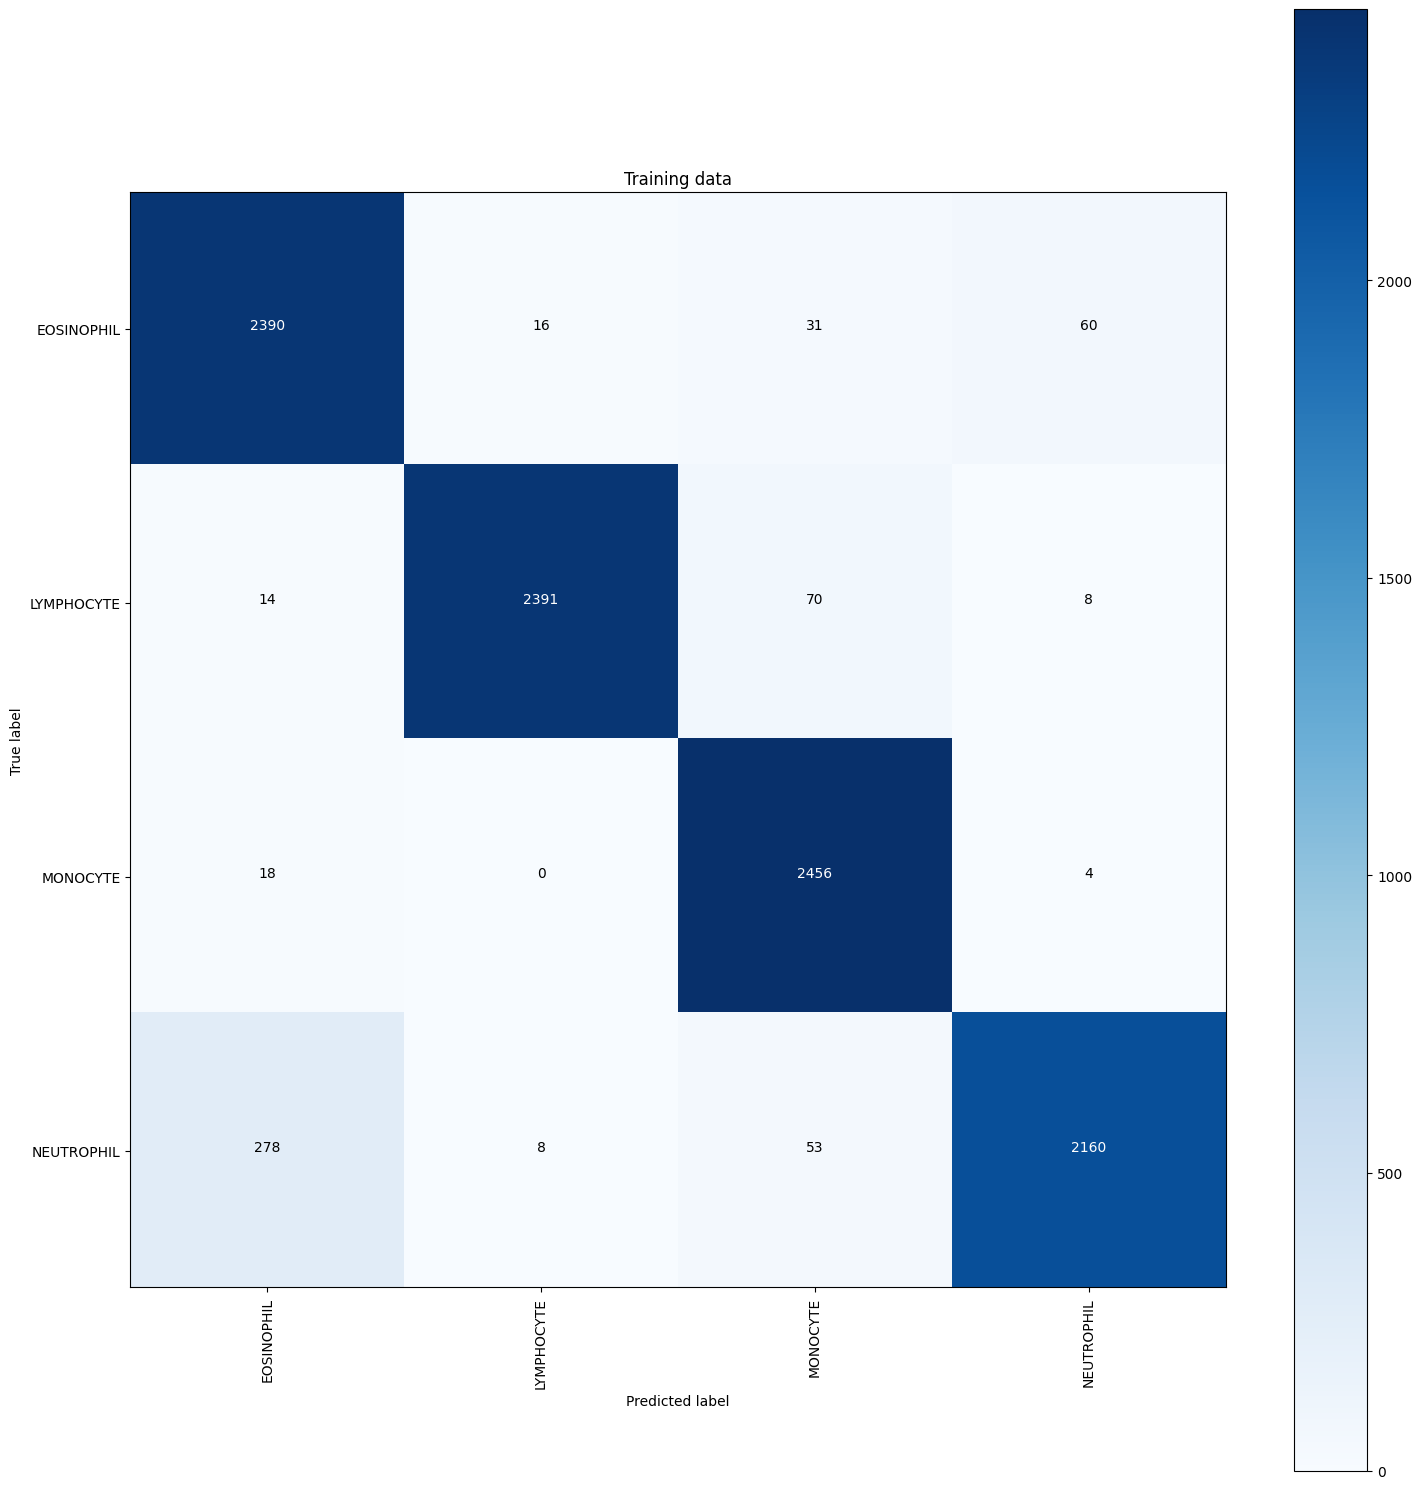

In [13]:
# Create and display confusion matrix for the training data
cm, class_names_training = utils.get_confusion_matrix(model, gen, src_path_training, image_size)
utils.plot_confusion_matrix(cm, class_names_training, 'Training data')

Creating a confusion matrix
Found 2487 images belonging to 4 classes.


  0%|                                                                                                                                                                                            | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|██▎                                                                                                                                                                                 | 1/78 [00:00<00:12,  6.04it/s]

1/1 [==============================] - 0s 28ms/step


  3%|████▌                                                                                                                                                                               | 2/78 [00:00<00:12,  6.19it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██████▉                                                                                                                                                                             | 3/78 [00:00<00:11,  6.26it/s]

1/1 [==============================] - 0s 25ms/step


  5%|█████████▏                                                                                                                                                                          | 4/78 [00:00<00:11,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


  6%|███████████▌                                                                                                                                                                        | 5/78 [00:00<00:11,  6.38it/s]

1/1 [==============================] - 0s 29ms/step


  8%|█████████████▊                                                                                                                                                                      | 6/78 [00:00<00:11,  6.43it/s]

1/1 [==============================] - 0s 30ms/step


  9%|████████████████▏                                                                                                                                                                   | 7/78 [00:01<00:11,  6.36it/s]

1/1 [==============================] - 0s 27ms/step


 10%|██████████████████▍                                                                                                                                                                 | 8/78 [00:01<00:10,  6.48it/s]

1/1 [==============================] - 0s 28ms/step


 12%|████████████████████▊                                                                                                                                                               | 9/78 [00:01<00:10,  6.40it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████████████████▉                                                                                                                                                            | 10/78 [00:01<00:10,  6.19it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█████████████████████████▏                                                                                                                                                         | 11/78 [00:01<00:10,  6.19it/s]

1/1 [==============================] - 0s 25ms/step


 15%|███████████████████████████▌                                                                                                                                                       | 12/78 [00:01<00:10,  6.28it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████████████████████▊                                                                                                                                                     | 13/78 [00:02<00:10,  6.30it/s]

1/1 [==============================] - 0s 28ms/step


 18%|████████████████████████████████▏                                                                                                                                                  | 14/78 [00:02<00:10,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


 19%|██████████████████████████████████▍                                                                                                                                                | 15/78 [00:02<00:09,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


 21%|████████████████████████████████████▋                                                                                                                                              | 16/78 [00:02<00:09,  6.41it/s]

1/1 [==============================] - 0s 27ms/step


 22%|███████████████████████████████████████                                                                                                                                            | 17/78 [00:02<00:09,  6.35it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████████████████████████████▎                                                                                                                                         | 18/78 [00:02<00:09,  6.32it/s]

1/1 [==============================] - 0s 28ms/step


 24%|███████████████████████████████████████████▌                                                                                                                                       | 19/78 [00:03<00:09,  6.34it/s]

1/1 [==============================] - 0s 29ms/step


 26%|█████████████████████████████████████████████▉                                                                                                                                     | 20/78 [00:03<00:09,  6.18it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████████████████████████████████▏                                                                                                                                  | 21/78 [00:03<00:09,  6.20it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██████████████████████████████████████████████████▍                                                                                                                                | 22/78 [00:03<00:08,  6.24it/s]

1/1 [==============================] - 0s 29ms/step


 29%|████████████████████████████████████████████████████▊                                                                                                                              | 23/78 [00:03<00:08,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███████████████████████████████████████████████████████                                                                                                                            | 24/78 [00:03<00:08,  6.34it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████████████████████████████████████████████████▎                                                                                                                         | 25/78 [00:03<00:08,  6.31it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███████████████████████████████████████████████████████████▋                                                                                                                       | 26/78 [00:04<00:08,  6.33it/s]

1/1 [==============================] - 0s 28ms/step


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                     | 27/78 [00:04<00:07,  6.38it/s]

1/1 [==============================] - 0s 28ms/step


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                  | 28/78 [00:04<00:07,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


 37%|██████████████████████████████████████████████████████████████████▌                                                                                                                | 29/78 [00:04<00:07,  6.44it/s]

1/1 [==============================] - 0s 32ms/step


 38%|████████████████████████████████████████████████████████████████████▊                                                                                                              | 30/78 [00:04<00:07,  6.38it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                           | 31/78 [00:04<00:07,  6.39it/s]

1/1 [==============================] - 0s 32ms/step


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                         | 32/78 [00:05<00:07,  6.34it/s]

1/1 [==============================] - 0s 29ms/step


 42%|███████████████████████████████████████████████████████████████████████████▋                                                                                                       | 33/78 [00:05<00:07,  6.34it/s]

1/1 [==============================] - 0s 28ms/step


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                     | 34/78 [00:05<00:06,  6.36it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 35/78 [00:05<00:06,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


 46%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 36/78 [00:05<00:06,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 37/78 [00:05<00:06,  6.38it/s]

1/1 [==============================] - 0s 28ms/step


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 38/78 [00:05<00:06,  6.39it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 39/78 [00:06<00:06,  6.40it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 40/78 [00:06<00:06,  6.20it/s]

1/1 [==============================] - 0s 28ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 41/78 [00:06<00:05,  6.23it/s]

1/1 [==============================] - 0s 28ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 42/78 [00:06<00:05,  6.29it/s]

1/1 [==============================] - 0s 28ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 43/78 [00:06<00:05,  6.28it/s]

1/1 [==============================] - 0s 31ms/step


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 44/78 [00:06<00:05,  6.25it/s]

1/1 [==============================] - 0s 28ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 45/78 [00:07<00:05,  6.30it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 46/78 [00:07<00:05,  6.20it/s]

1/1 [==============================] - 0s 29ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 47/78 [00:07<00:04,  6.25it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 48/78 [00:07<00:04,  6.30it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 49/78 [00:07<00:04,  6.20it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 50/78 [00:07<00:04,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 51/78 [00:08<00:04,  6.12it/s]

1/1 [==============================] - 0s 27ms/step


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 52/78 [00:08<00:04,  6.23it/s]

1/1 [==============================] - 0s 28ms/step


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 53/78 [00:08<00:03,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 54/78 [00:08<00:03,  6.24it/s]

1/1 [==============================] - 0s 31ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 55/78 [00:08<00:03,  6.23it/s]

1/1 [==============================] - 0s 27ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 56/78 [00:08<00:03,  6.23it/s]

1/1 [==============================] - 0s 29ms/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 57/78 [00:09<00:03,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 58/78 [00:09<00:03,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 59/78 [00:09<00:03,  6.22it/s]

1/1 [==============================] - 0s 36ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 60/78 [00:09<00:03,  5.86it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 61/78 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 34ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 62/78 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 63/78 [00:10<00:02,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 64/78 [00:10<00:02,  5.86it/s]

1/1 [==============================] - 0s 30ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 65/78 [00:10<00:02,  5.73it/s]

1/1 [==============================] - 0s 29ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 66/78 [00:10<00:02,  5.78it/s]

1/1 [==============================] - 0s 32ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 67/78 [00:10<00:01,  5.66it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 68/78 [00:10<00:01,  5.84it/s]

1/1 [==============================] - 0s 28ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 69/78 [00:11<00:01,  5.93it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 70/78 [00:11<00:01,  5.77it/s]

1/1 [==============================] - 0s 29ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 71/78 [00:11<00:01,  5.90it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 72/78 [00:11<00:00,  6.08it/s]

1/1 [==============================] - 0s 24ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 73/78 [00:11<00:00,  6.17it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74/78 [00:11<00:00,  6.11it/s]

1/1 [==============================] - 0s 25ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75/78 [00:12<00:00,  6.05it/s]

1/1 [==============================] - 0s 24ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76/78 [00:12<00:00,  6.10it/s]

1/1 [==============================] - 0s 28ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 77/78 [00:12<00:00,  6.09it/s]

1/1 [==============================] - 0s 162ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 77/78 [00:12<00:00,  6.07it/s]


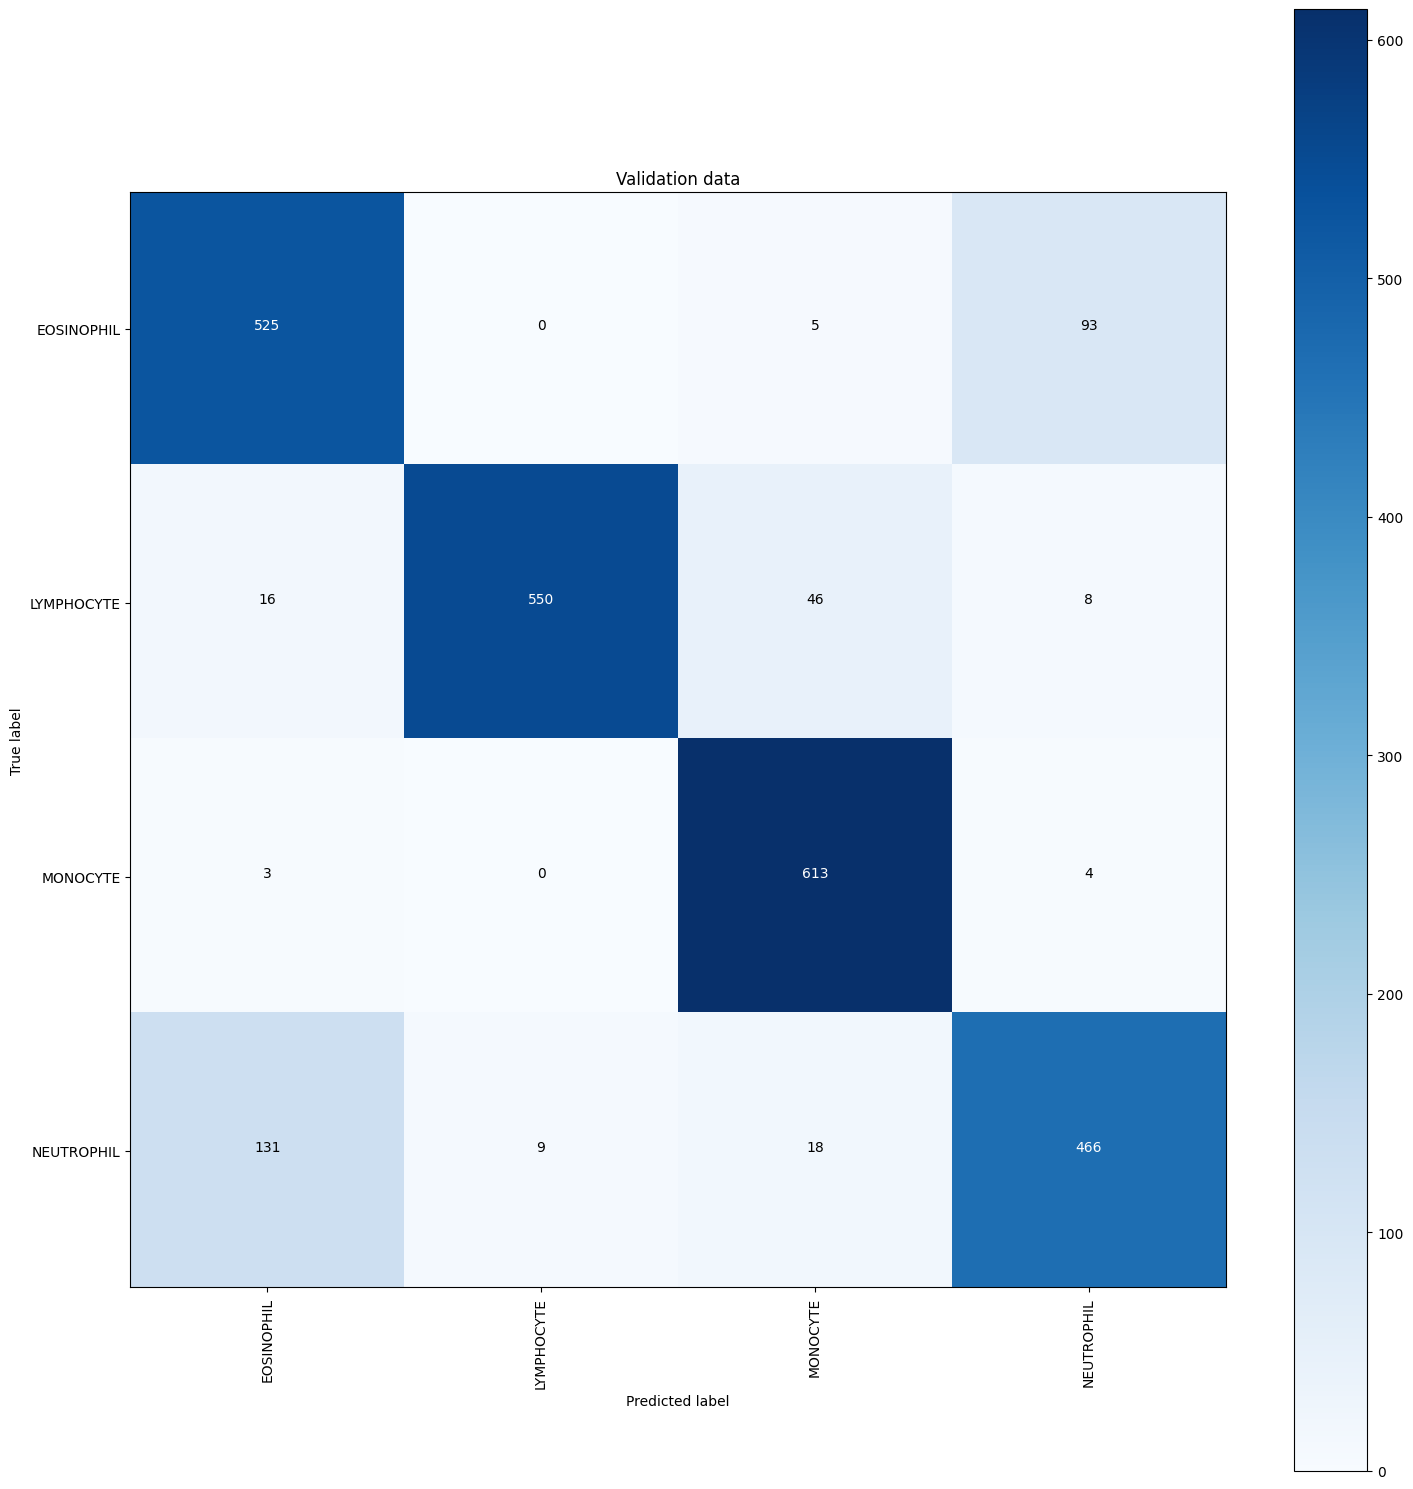

In [14]:
# Create and display confusion matrix for the validation data
validation_cm, class_names_validation = utils.get_confusion_matrix(model, gen, src_path_test, image_size)
utils.plot_confusion_matrix(validation_cm, class_names_validation, 'Validation data')

In [15]:
# Calculate accuracy for training data
print(f'Accuracy for training data: {np.trace(cm) / cm.sum()}')

# Calculate accuracy for validation data
print(f'Accuracy for training data: {np.trace(validation_cm) / validation_cm.sum()}')

Accuracy for training data: 0.94375816008838
Accuracy for training data: 0.8661037394451147
